In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import numpy as np

file_path="D:/mimic_iii/csv/"

In [2]:
adm=pd.read_csv(file_path+"ADMISSIONS.csv")
adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [3]:
#Load the patients data base and add the Date of birth to the admission dataset.
patients_df=pd.read_csv(file_path+"PATIENTS.csv")
patients_df["DOBTIME"]=pd.to_datetime(patients_df["DOB"], format='%Y-%m-%d')
patients_df[["SUBJECT_ID","DOBTIME"]].head()
adm_dob=pd.merge(patients_df[["SUBJECT_ID","DOBTIME"]],adm,on="SUBJECT_ID")

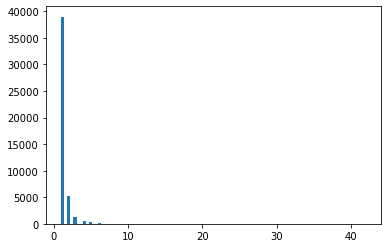

Number of patients with specific number of admissions : 
 1     38983
2      5160
3      1342
4       508
5       246
6       113
7        51
8        31
9        26
10       14
11       13
12        8
13        5
14        4
17        3
16        2
34        2
24        1
42        1
15        1
19        1
20        1
21        1
22        1
23        1
31        1
Name: HADM_ID, dtype: int64


In [4]:
#Number of admissions by patient
df=adm.groupby("SUBJECT_ID")["HADM_ID"].nunique()
plt.hist(df,bins=100)
plt.show()
print("Number of patients with specific number of admissions : \n",df.value_counts())

As the majortity of patients only present a single admission, we filter out all the patients with more than 1 admission

In [5]:
subj_ids=list(df[df==1].index) #index of patients with only one visit.
adm_1=adm_dob.loc[adm_dob["SUBJECT_ID"].isin(subj_ids)] #filter out the patients with more than one visit
print("Number of patients remaining in the dataframe: ")
print(len(adm_1.index))


Number of patients remaining in the dataframe: 
38983


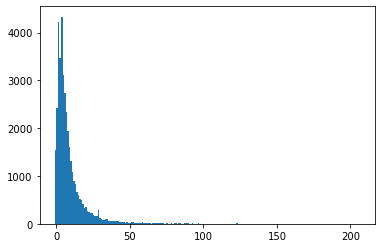

Number of patients with specific duration of admissions in days : 
 4      4333
2      4216
3      3478
5      3119
6      2739
       ... 
121       1
151       1
163       1
169       1
202       1
Name: ELAPSED_DAYS, Length: 156, dtype: int64


In [6]:
#We now add a new column with the duration of each stay.
adm_1=adm_1.copy()
adm_1['ADMITTIME']=pd.to_datetime(adm_1["ADMITTIME"], format='%Y-%m-%d %H:%M:%S')
adm_1['DISCHTIME']=pd.to_datetime(adm_1["DISCHTIME"], format='%Y-%m-%d %H:%M:%S')

adm_1["ELAPSED_TIME"]=adm_1["DISCHTIME"]-adm_1["ADMITTIME"]
adm_1.head()
adm_1["ELAPSED_DAYS"]=adm_1["ELAPSED_TIME"].dt.days #Elapsed time in days in ICU
plt.hist(adm_1["ELAPSED_DAYS"],bins=200)
plt.show()
print("Number of patients with specific duration of admissions in days : \n",adm_1["ELAPSED_DAYS"].value_counts())

In [49]:
adm_1["ELAPSED_DAYS"].value_counts().head(20)
sum(adm_1["ELAPSED_DAYS"]<30)

37031

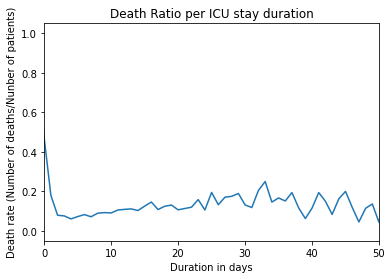

In [33]:
#Let's now report the death rate in function of the duration stay in Hospital.
adm_1["DEATHTAG"]=0
adm_1.loc[adm_1.DEATHTIME.notnull(),"DEATHTAG"]=1

df_deaths_per_duration=adm_1.groupby("ELAPSED_DAYS")["DEATHTAG"].sum()
df_patients_per_duration=adm_1.groupby("ELAPSED_DAYS")["SUBJECT_ID"].nunique()
df_death_ratio_per_duration=df_deaths_per_duration/df_patients_per_duration
plt.plot(df_death_ratio_per_duration)
plt.title("Death Ratio per ICU stay duration")
plt.xlabel("Duration in days")
plt.ylabel("Death rate (Number of deaths/Nunber of patients)")
plt.xlim(0,50)
plt.show()

Given the results above, we select patients with a least 48 hours in the ICU and with less than 30 days stay.

In [8]:
adm_2=adm_1.loc[(adm_1["ELAPSED_DAYS"]<30) & (adm_1["ELAPSED_DAYS"]>2)]
print("Number of patients remaining in the dataframe: ")
print(len(adm_2.index))

Number of patients remaining in the dataframe: 
28840


we remove patients older than 89, whose date of birth have been set to exactly 300 years before their first admission. In MIMIC dataset, the date tend to be shifted 100 year later.

In [9]:
adm_2_90=adm_2.loc[adm_2["DOBTIME"]>pd.to_datetime("1950-01-01",format='%Y-%m-%d')].copy()
print(len(adm_2_90.index))

27614


We remove the patients who are younger than 15 at admission time

In [10]:
adm_2_15=adm_2_90.loc[((pd.to_datetime(adm_2_90["ADMITTIME"].dt.date)-adm_2_90["DOBTIME"]).dt.days/365)>15].copy()
print("Number of patients remaining in the dataframe: ")
print(len(adm_2_15.index))

Number of patients remaining in the dataframe: 
23495


We remove the admissions with no chart events data.

In [11]:
adm_2_15_chart=adm_2_15.loc[adm_2_15["HAS_CHARTEVENTS_DATA"]==1].copy()
print("Number of patients remaining in the dataframe: ")
print(len(adm_2_15_chart.index))

Number of patients remaining in the dataframe: 
23465


In [12]:
#We now investigate the admission_type
df_type=adm_2_15_chart.groupby("ADMISSION_TYPE")["SUBJECT_ID"].count()
df_type

ADMISSION_TYPE
ELECTIVE      4577
EMERGENCY    18187
URGENT         701
Name: SUBJECT_ID, dtype: int64

We remove the newborns as they are specific

In [13]:
adm_3=adm_2_15_chart.loc[adm_2_15_chart["ADMISSION_TYPE"]!="NEWBORN"]
print("Number of patients remaining in the dataframe: ")
print(adm_3["SUBJECT_ID"].nunique())

adm_3.to_csv(file_path+"./Admissions_processed.csv")

Number of patients remaining in the dataframe: 
23465


## INPUTS EVENTS DATA

We now consider the inputevents dataset. We select only the patients in the metavision system and with the same criteria as above.

In [14]:
inputs=pd.read_csv(file_path+"INPUTEVENTS_MV.csv")
#Restrict the dataset to the previously selected admission ids only.
adm_ids=list(adm_3["HADM_ID"])
inputs=inputs.loc[inputs["HADM_ID"].isin(adm_ids)]

#Inputs_small only contains the columns of interest.
inputs_small=inputs[["SUBJECT_ID","HADM_ID","STARTTIME","ENDTIME","ITEMID","AMOUNT","AMOUNTUOM","RATE","RATEUOM","PATIENTWEIGHT","ORDERCATEGORYDESCRIPTION"]]
print(inputs_small.head())

print("Number of patients remaining in the database: ")
print(inputs_small["SUBJECT_ID"].nunique())

   SUBJECT_ID  HADM_ID            STARTTIME              ENDTIME  ITEMID  \
0       27063   139787  2133-02-05 06:29:00  2133-02-05 08:45:00  225166   
1       27063   139787  2133-02-05 05:34:00  2133-02-05 06:30:00  225944   
2       27063   139787  2133-02-05 05:34:00  2133-02-05 06:30:00  225166   
3       27063   139787  2133-02-03 12:00:00  2133-02-03 12:01:00  225893   
4       27063   139787  2133-02-03 12:00:00  2133-02-03 12:01:00  220949   

       AMOUNT AMOUNTUOM       RATE  RATEUOM  PATIENTWEIGHT  \
0    6.774532       mEq        NaN      NaN           83.2   
1   28.132997        ml  30.142497  mL/hour           83.2   
2    2.813300       mEq        NaN      NaN           83.2   
3    1.000000      dose        NaN      NaN           83.2   
4  100.000000        ml        NaN      NaN           83.2   

  ORDERCATEGORYDESCRIPTION  
0            Continuous IV  
1            Continuous IV  
2            Continuous IV  
3                Drug Push  
4                Drug Pus

We load the D_ITEMS dataframe which contains the name of the ITEMID. And we merge both tables together.

In [15]:
#item_id 
item_id=pd.read_csv(file_path+"D_ITEMS.csv")
item_id_1=item_id[["ITEMID","LABEL"]]
item_id_1.head()

#We merge the name of the item administrated.
inputs_small_2=pd.merge(inputs_small,item_id_1,on="ITEMID")
inputs_small_2.head()
print("Number of patients remaining in the database: ")
print(inputs_small_2["SUBJECT_ID"].nunique())

Number of patients remaining in the database: 
10100


In [16]:
#For each item, evaluate the number of patients who have been given this item.
pat_for_item=inputs_small_2.groupby("LABEL")["SUBJECT_ID"].nunique()
#Order by occurence and take the 33 best (the ones with the most patients)
frequent_labels=pat_for_item.sort_values(ascending=False)[:50]

#Select only the time series with high occurence.
inputs_small_3=inputs_small_2.loc[inputs_small_2["LABEL"].isin(list(frequent_labels.index))].copy()

print("Number of patients remaining in the database: ")
print(inputs_small_3["SUBJECT_ID"].nunique())

Number of patients remaining in the database: 
10099


In [17]:
#Only select specific labels for the inputs.
#list of retained inputs :
retained_list=["Albumin 5%","Dextrose 5%","Lorazepam (Ativan)","Calcium Gluconate","Midazolam (Versed)","Phenylephrine","Furosemide (Lasix)","Hydralazine","Norepinephrine","Magnesium Sulfate","Nitroglycerin","Insulin - Glargine","Insulin - Humalog","Insulin - Regular","Heparin Sodium","Morphine Sulfate","Potassium Chloride","Packed Red Blood Cells","Gastric Meds","D5 1/2NS","LR","K Phos","Solution","Sterile Water","Metoprolol","Piggyback","OR Crystalloid Intake","OR Cell Saver Intake","PO Intake","GT Flush","KCL (Bolus)","Magnesium Sulfate (Bolus)"]
#missing :Fresh Frozen Plasma
inputs_small_3=inputs_small_3.loc[inputs_small_3["LABEL"].isin(retained_list)].copy()



# Cleaning of the input data

### Units Cleaning

#### 1) Amounts

In [18]:
#Verification that all input labels have the same amounts units.
inputs_small_3.groupby("LABEL")["AMOUNTUOM"].value_counts()

LABEL                      AMOUNTUOM
Albumin 5%                 ml             4050
Calcium Gluconate          grams         12193
D5 1/2NS                   ml             8322
Dextrose 5%                ml           191961
Furosemide (Lasix)         mg            21904
GT Flush                   ml            26003
Gastric Meds               ml            38580
Heparin Sodium             units         14522
Hydralazine                mg             7310
Insulin - Glargine         units          4127
Insulin - Humalog          units         12671
Insulin - Regular          units         65047
K Phos                     mmol           3002
KCL (Bolus)                ml            21302
LR                         ml            29414
Lorazepam (Ativan)         mg             9660
Magnesium Sulfate          grams         13120
                           mg                1
Magnesium Sulfate (Bolus)  ml             9283
Metoprolol                 mg            15485
                       

In [19]:
##### Cleaning the Cefazolin (remove the ones that are not in dose unit)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["ITEMID"]==225850) & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Cefepime (remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Cefepime") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Ceftriaxone (remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Ceftriaxone") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Ciprofloxacin (remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Ciprofloxacin") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Famotidine (Pepcid) (remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Famotidine (Pepcid)") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Fentanyl (Concentrate) (remove the non mg)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl (Concentrate)") & (inputs_small_3["AMOUNTUOM"]!="mg")].index).copy()
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl (Concentrate)") & (inputs_small_3["AMOUNTUOM"]=="mg"),"AMOUNT"]*=1000
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl (Concentrate)") & (inputs_small_3["AMOUNTUOM"]=="mg"),"AMOUNTUOM"]="mcg"
#Cleaning the Heparin Sodium (Prophylaxis) (remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Heparin Sodium (Prophylaxis)") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Hydromorphone (Dilaudid) (remove the non mg)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Hydromorphone (Dilaudid)") & (inputs_small_3["AMOUNTUOM"]!="mg")].index).copy()
#Cleaning the Magnesium Sulfate (remove the non grams)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Magnesium Sulfate") & (inputs_small_3["AMOUNTUOM"]!="grams")].index).copy()
#Cleaning the Propofol (remove the non mg)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Propofol") & (inputs_small_3["AMOUNTUOM"]!="mg")].index).copy()
#Cleaning the Metoprolol (remove the non mg)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Metoprolol") & (inputs_small_3["AMOUNTUOM"]!="mg")].index).copy()
#Cleaning the Piperacillin/Tazobactam (Zosyn) (remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Piperacillin/Tazobactam (Zosyn)") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Metronidazole (remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Metronidazole") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Ranitidine (Prophylaxis)(remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Ranitidine (Prophylaxis)") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Vancomycin (remove the non dose)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Vancomycin") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()
#Cleaning the Fentanyl. Put the mg to mcg 
inputs_small_3.loc[(inputs_small_3["ITEMID"]==221744) & (inputs_small_3["AMOUNTUOM"]=="mg"),"AMOUNT"]*=1000
inputs_small_3.loc[(inputs_small_3["ITEMID"]==221744) & (inputs_small_3["AMOUNTUOM"]=="mg"),"AMOUNTUOM"]="mcg"
#Cleaning of the Pantoprazole (Protonix)
    #divide in two (drug shot or continuous treatment and create a new item id for the continuous version)
inputs_small_3.loc[(inputs_small_3["ITEMID"]==225910) & (inputs_small_3["ORDERCATEGORYDESCRIPTION"]=="Continuous Med"),"LABEL"]="Pantoprazole (Protonix) Continuous"
inputs_small_3.loc[(inputs_small_3["ITEMID"]==225910) & (inputs_small_3["ORDERCATEGORYDESCRIPTION"]=="Continuous Med"),"ITEMID"]=2217441
#remove the non dose from the drug shot version
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Pantoprazole (Protonix)") & (inputs_small_3["AMOUNTUOM"]!="dose")].index).copy()


#Verification that all input labels have the same units.
inputs_small_3.groupby("LABEL")["AMOUNTUOM"].value_counts()

LABEL                      AMOUNTUOM
Albumin 5%                 ml             4050
Calcium Gluconate          grams         12193
D5 1/2NS                   ml             8322
Dextrose 5%                ml           191961
Furosemide (Lasix)         mg            21904
GT Flush                   ml            26003
Gastric Meds               ml            38580
Heparin Sodium             units         14522
Hydralazine                mg             7310
Insulin - Glargine         units          4127
Insulin - Humalog          units         12671
Insulin - Regular          units         65047
K Phos                     mmol           3002
KCL (Bolus)                ml            21302
LR                         ml            29414
Lorazepam (Ativan)         mg             9660
Magnesium Sulfate          grams         13120
Magnesium Sulfate (Bolus)  ml             9283
Metoprolol                 mg            15485
Midazolam (Versed)         mg            33687
Morphine Sulfate       

#### 2) Rates

In [1]:
inputs_small_3.groupby("LABEL")["RATEUOM"].value_counts()

NameError: name 'inputs_small_3' is not defined

In [21]:
#Cleaning of Dextrose 5%  (remove the non mL/hour)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Dextrose 5%") & (inputs_small_3["RATEUOM"]!="mL/hour")].index).copy()
#Cleaning of Magnesium Sulfate (Bolus)  (remove the non mL/hour)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Magnesium Sulfate (Bolus)") & (inputs_small_3["RATEUOM"]!="mL/hour")].index).copy()
#Cleaning of NaCl 0.9% (remove the non mL/hour)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="NaCl 0.9%") & (inputs_small_3["RATEUOM"]!="mL/hour")].index).copy()
#Cleaning of Piggyback (remove the non mL/hour)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Piggyback") & (inputs_small_3["RATEUOM"]!="mL/hour")].index).copy()
#Cleaning of Packed Red Bllod Cells (remove the non mL/hour)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Packed Red Blood Cells") & (inputs_small_3["RATEUOM"]!="mL/hour")].index).copy()


#Check if a single unit per drug
inputs_small_3.groupby("LABEL")["RATEUOM"].value_counts()

LABEL                      RATEUOM   
Albumin 5%                 mL/hour         4050
D5 1/2NS                   mL/hour         8299
Dextrose 5%                mL/hour       106902
Furosemide (Lasix)         mg/hour         8843
Heparin Sodium             units/hour     13413
Hydralazine                mg/hour            2
Insulin - Regular          units/hour     30520
KCL (Bolus)                mL/hour        21302
LR                         mL/hour        18543
Lorazepam (Ativan)         mg/hour          104
Magnesium Sulfate (Bolus)  mL/hour         9281
Midazolam (Versed)         mg/hour        19412
Morphine Sulfate           mg/hour         2004
Nitroglycerin              mcg/kg/min     21664
Norepinephrine             mcg/kg/min     34950
Packed Red Blood Cells     mL/hour        10454
Phenylephrine              mcg/kg/min     46652
Piggyback                  mL/hour        17934
Solution                   mL/hour       115980
Sterile Water              mL/hour        11605
Na

### Check for outliers

#### 1) In amounts

In [22]:
inputs_small_3.groupby("LABEL")["AMOUNT"].describe()

,count,mean,std,min,25%,50%,75%,max
LABEL,,,,,,,,
Albumin 5%,4050.0,388.369612,166.110714,-149.999994,249.999990,499.999980,499.999980,5199.999792
Calcium Gluconate,12193.0,2.405072,3.491139,-0.933333,2.000000,2.000000,2.000000,199.999998
D5 1/2NS,8322.0,636.180349,439.026112,-918.173907,201.666662,778.314861,999.999972,5999.999904
Dextrose 5%,106902.0,115.524221,191.605066,-5250.000000,6.577475,47.717591,153.333326,5000.000040
Furosemide (Lasix),21904.0,35.477109,44.378339,-120.000009,16.098319,20.000001,40.000003,2320.000200
GT Flush,26003.0,48.559512,63.428421,-3750.000000,30.000000,30.000000,50.000000,2000.000000
Gastric Meds,38580.0,66.776721,1226.688211,-5400.000000,30.000000,40.000000,60.000000,240120.000000
Heparin Sodium,14522.0,9512.448239,9765.479419,-525000.000000,2157.095630,6858.147894,15555.605203,30640.000300
Hydralazine,7310.0,11.922217,28.098023,-240.000012,10.000001,10.000001,10.000001,2350.000100


In [23]:
#Clean Albumin 5%
#Invert start time and end time
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Albumin 5%") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Albumin 5%") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Albumin 5%") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Albumin 5%") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]=a
#Positive rate
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Albumin 5%") & (inputs_small_3["AMOUNT"]<0),"AMOUNT"]*=-1

#Clean Calcium Gluconate
#Invert start time and end time
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Calcium Gluconate") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Calcium Gluconate") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Calcium Gluconate") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Calcium Gluconate") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]=a
#Positive rate
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Calcium Gluconate") & (inputs_small_3["AMOUNT"]<0),"AMOUNT"]*=-1
#Remove entries with more 10 grams.
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Calcium Gluconate") & (inputs_small_3["AMOUNT"]>10)].index).copy()


#Clean Cefazolin
#Invert start time and end time
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Cefazolin") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Cefazolin") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Cefazolin") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Cefazolin") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]=a
#Positive rate
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Cefazolin") & (inputs_small_3["AMOUNT"]<0),"AMOUNT"]*=-1
#Remove entries with more than 2 doses amount.
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Cefazolin") & (inputs_small_3["AMOUNT"]>2)].index).copy()

#Clean Cefepime
#Remove the negative entries (they are anyway too large in the positive range as well.)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Cefepime") & (inputs_small_3["AMOUNT"]<0)].index).copy()

#Clean Ceftriaxone
#Remove the negative entries (they are anyway too large in the positive range as well.)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Ceftriaxone") & (inputs_small_3["AMOUNT"]<0)].index).copy()

#Clean Ciprofloxacin
#Remove the negative entries (they are anyway too large in the positive range as well.)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Ciprofloxacin") & (inputs_small_3["AMOUNT"]<0)].index).copy()

#Clean D5 1/2NS
#Invert start time and end time
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="D5 1/2NS") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]
inputs_small_3.loc[(inputs_small_3["LABEL"]=="D5 1/2NS") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]=inputs_small_3.loc[(inputs_small_3["LABEL"]=="D5 1/2NS") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="D5 1/2NS") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]=a
#Positive rate
inputs_small_3.loc[(inputs_small_3["LABEL"]=="D5 1/2NS") & (inputs_small_3["AMOUNT"]<0),"AMOUNT"]*=-1

#Clean Dextrose 5%
#Invert start time and end time
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Dextrose 5%") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Dextrose 5%") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Dextrose 5%") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Dextrose 5%") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]=a
#Positive rate
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Dextrose 5%") & (inputs_small_3["AMOUNT"]<0),"AMOUNT"]*=-1

#Clean Famotidine (Pepcid)
#Remove the negative entries (they are anyway too large in the positive range as well.)
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Famotidine (Pepcid)") & (inputs_small_3["AMOUNT"]<0)].index).copy()
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Famotidine (Pepcid)") & (inputs_small_3["AMOUNT"]>1)].index).copy()

#Clean Fentanyl
#Invert start time and end time
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]=a
#Positive rate
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl") & (inputs_small_3["AMOUNT"]<0),"AMOUNT"]*=-1

#Clean Fentanyl (Concentrate)
#Invert start time and end time
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl (Concentrate)") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl (Concentrate)") & (inputs_small_3["AMOUNT"]<0),"STARTTIME"]=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl (Concentrate)") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]
a=inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl (Concentrate)") & (inputs_small_3["AMOUNT"]<0),"ENDTIME"]=a
#Positive rate
inputs_small_3.loc[(inputs_small_3["LABEL"]=="Fentanyl (Concentrate)") & (inputs_small_3["AMOUNT"]<0),"AMOUNT"]*=-1


#Check if all remaining negative values are linked to the swapping the start and end times.
inputs_small_3['STARTTIME']=pd.to_datetime(inputs_small_3["STARTTIME"], format='%Y-%m-%d %H:%M:%S')
inputs_small_3['ENDTIME']=pd.to_datetime(inputs_small_3["ENDTIME"], format='%Y-%m-%d %H:%M:%S')
inputs_small_3["DURATION"]=inputs_small_3['ENDTIME']-inputs_small_3['STARTTIME']
print(inputs_small_3.loc[(inputs_small_3["AMOUNT"]<0)&(inputs_small_3["DURATION"]>timedelta(0))]) #All are inverted

#Revert all the remaining negative values to the positive range.
a=inputs_small_3.loc[inputs_small_3["AMOUNT"]<0,"STARTTIME"]
inputs_small_3.loc[inputs_small_3["AMOUNT"]<0,"STARTTIME"]=inputs_small_3.loc[inputs_small_3["AMOUNT"]<0,"ENDTIME"]
a=inputs_small_3.loc[inputs_small_3["AMOUNT"]<0,"ENDTIME"]=a
#Positive rate
inputs_small_3.loc[inputs_small_3["AMOUNT"]<0,"AMOUNT"]*=-1
#Recompute the durations with the correct time stamps for start and end.
inputs_small_3["DURATION"]=inputs_small_3['ENDTIME']-inputs_small_3['STARTTIME']

#Clean Gastric Meds, remove too large values
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Gastric Meds") & (inputs_small_3["AMOUNT"]>5000)].index).copy()

#Clean Heparin Sodium, remove too large values
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Heparin Sodium") & (inputs_small_3["AMOUNT"]>50000)].index).copy()

#Clean Heparin Sodium (Prophylaxis), remove too large values
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Heparin Sodium (Prophylaxis)") & (inputs_small_3["AMOUNT"]>2)].index).copy()

#Clean Hydralazine, remove too large values
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Hydralazine") & (inputs_small_3["AMOUNT"]>200)].index).copy()

#Clean Hydromorphone (Dilaudid), remove too large values
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Hydromorphone (Dilaudid)") & (inputs_small_3["AMOUNT"]>500)].index).copy()

#Clean Insulin - Humalog, remove too large values
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Insulin - Humalog") & (inputs_small_3["AMOUNT"]>100)].index).copy()

#Clean Insulin - Regular, remove too large values
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Insulin - Regular") & (inputs_small_3["AMOUNT"]>1000)].index).copy()

#Clean Magnesium Sulfate, remove too large values
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="Magnesium Sulfate") & (inputs_small_3["AMOUNT"]>51)].index).copy()

#To be continued ...

Empty DataFrame
Columns: [SUBJECT_ID, HADM_ID, STARTTIME, ENDTIME, ITEMID, AMOUNT, AMOUNTUOM, RATE, RATEUOM, PATIENTWEIGHT, ORDERCATEGORYDESCRIPTION, LABEL, DURATION]
Index: []


#### 2) In rates

In [24]:
inputs_small_3.groupby("LABEL")["RATE"].describe()

,count,mean,std,min,25%,50%,75%,max
LABEL,,,,,,,,
Albumin 5%,4050.0,466.432805,249.881876,25.000000,249.999990,499.999980,499.999980,4.285714e+03
Calcium Gluconate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D5 1/2NS,8299.0,107.856254,679.450735,1.006036,75.000000,80.002686,100.502514,5.959800e+04
Dextrose 5%,106902.0,44.410480,336.420551,0.000000,9.628070,14.985362,30.133583,2.537500e+04
Furosemide (Lasix),8843.0,9.198524,10.810320,0.050000,4.457647,7.996508,12.038351,6.357810e+02
GT Flush,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gastric Meds,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heparin Sodium,13411.0,1960.233342,16709.719397,10.500053,900.609870,1218.853140,1662.627330,1.500000e+06
Hydralazine,2.0,45.000004,7.071069,40.000003,42.500004,45.000004,47.500004,5.000000e+01


In [25]:
#Clean D5 1/2NS Remove too large rates
inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]=="D5 1/2NS") & (inputs_small_3["RATE"]>1000)].index).copy()

#Remove all entries whose rate is more than 4 std away from the mean.
rate_desc=inputs_small_3.groupby("LABEL")["RATE"].describe()
name_list=list(rate_desc.loc[rate_desc["count"]!=0].index)
for label in name_list:
    inputs_small_3=inputs_small_3.drop(inputs_small_3.loc[(inputs_small_3["LABEL"]==label)&(inputs_small_3["RATE"]>(rate_desc.loc[label,"mean"]+4*rate_desc.loc[label,"std"]))].index).copy()

In [26]:
inputs_small_3.groupby("LABEL")["RATE"].describe()

,count,mean,std,min,25%,50%,75%,max
LABEL,,,,,,,,
Albumin 5%,4040.0,462.461521,234.013232,25.000000,249.999990,499.999980,499.999980,1250.000040
Calcium Gluconate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D5 1/2NS,8202.0,89.741701,46.449467,1.006036,75.000000,80.000004,100.214476,399.999990
Dextrose 5%,106684.0,34.317221,77.575143,0.000000,9.600108,14.974345,30.071384,1365.879240
Furosemide (Lasix),8828.0,8.952322,6.026809,0.050000,4.246872,7.996272,12.033467,51.974998
GT Flush,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gastric Meds,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Heparin Sodium,13375.0,1417.969830,1397.500690,10.500053,900.555060,1217.110980,1655.834310,66398.172000
Hydralazine,2.0,45.000004,7.071069,40.000003,42.500004,45.000004,47.500004,50.000005


## We now split the entries which are spread in time.

We chose the duration window for the sampling. here we choose 30 minutes. So every entry which has a rate and with duration larger than 1 hour, we split it into fixed times injections.



In [27]:
#First we check if when there is a duration, the amount is matching.

#First check the /hours units
df_temp=inputs_small_3.loc[(inputs_small_3["RATE"].notnull()) & (inputs_small_3["RATEUOM"].str.contains("hour"))].copy()
df_temp["COMPUTED_AMOUNT"]=df_temp["RATE"]*(df_temp["DURATION"].dt.total_seconds()/3600)

#Check with a 0.01 tolerance
assert(len(df_temp.loc[(abs(df_temp["COMPUTED_AMOUNT"]-df_temp["AMOUNT"])>0.01)].index)==0) #OK

#Second check the /min units
df_temp=inputs_small_3.loc[(inputs_small_3["RATE"].notnull()) & (inputs_small_3["RATEUOM"].str.contains("mL/min"))].copy()
df_temp["COMPUTED_AMOUNT"]=df_temp["RATE"]*(df_temp["DURATION"].dt.total_seconds()/60)

#Check with a 0.01 tolerance
assert(len(df_temp.loc[(abs(df_temp["COMPUTED_AMOUNT"]-df_temp["AMOUNT"])>0.01)].index)==0) #OK

#Third check the kg/min units
df_temp=inputs_small_3.loc[(inputs_small_3["RATE"].notnull()) & (inputs_small_3["RATEUOM"].str.contains("kg/min"))].copy()
df_temp["COMPUTED_AMOUNT"]=df_temp["RATE"]*(df_temp["DURATION"].dt.total_seconds()/60)*(df_temp["PATIENTWEIGHT"])

#Check with a 0.01 tolerance
assert(len(df_temp.loc[(abs(df_temp["COMPUTED_AMOUNT"]-1000*df_temp["AMOUNT"])>0.01)].index)==0) #OK

In [28]:
duration_split_hours=0.5
to_sec_fact=3600*duration_split_hours

#split data set in four.

#The first dataframe contains the entries with no rate but with extended duration inputs (over 0.5 hour)
df_temp1=inputs_small_3.loc[(inputs_small_3["DURATION"]>timedelta(hours=duration_split_hours)) & (inputs_small_3["RATE"].isnull())].copy().reset_index(drop=True)
#The second dataframe contains the entries with no rate and low duration entries (<0.5hour)
df_temp2=inputs_small_3.loc[(inputs_small_3["DURATION"]<=timedelta(hours=duration_split_hours)) & (inputs_small_3["RATE"].isnull())].copy().reset_index(drop=True)
#The third dataframe contains the entries with a rate and extended duration inputs (over 0.5 hour)
df_temp3=inputs_small_3.loc[(inputs_small_3["DURATION"]>timedelta(hours=duration_split_hours)) & (inputs_small_3["RATE"].notnull())].copy().reset_index(drop=True)
#The forth dataframe contains the entries with a rate and low duration entries (< 0.5 hour)
df_temp4=inputs_small_3.loc[(inputs_small_3["DURATION"]<=timedelta(hours=duration_split_hours)) & (inputs_small_3["RATE"].notnull())].copy().reset_index(drop=True)

#Check if split is complete
assert(len(df_temp1.index)+len(df_temp2.index)+len(df_temp3.index)+len(df_temp4.index)==len(inputs_small_3.index))



In [29]:
#We then process all of these dfs.
#In the first one, we need to duplicate the entries according to their duration and then divide each entry by the number of duplicates

#We duplicate the rows with the number bins for each injection
df_temp1["Repeat"]=np.ceil(df_temp1["DURATION"].dt.total_seconds()/to_sec_fact).astype(int)
df_new1=df_temp1.reindex(df_temp1.index.repeat(df_temp1["Repeat"]))
#We then create the admninistration time as a shifted version of the STARTTIME.
df_new1["CHARTTIME"]=df_new1.groupby(level=0)['STARTTIME'].transform(lambda x: pd.date_range(start=x.iat[0],freq=str(60*duration_split_hours)+'min',periods=len(x)))
#We divide each entry by the number of repeats
df_new1["AMOUNT"]=df_new1["AMOUNT"]/df_new1["Repeat"]


# In the third one, we do the same
#We duplicate the rows with the number bins for each injection
df_temp3["Repeat"]=np.ceil(df_temp3["DURATION"].dt.total_seconds()/to_sec_fact).astype(int)
df_new3=df_temp3.reindex(df_temp3.index.repeat(df_temp3["Repeat"]))
#We then create the admninistration time as a shifted version of the STARTTIME.
df_new3["CHARTTIME"]=df_new3.groupby(level=0)['STARTTIME'].transform(lambda x: pd.date_range(start=x.iat[0],freq=str(60*duration_split_hours)+'min',periods=len(x)))
#We divide each entry by the number of repeats
df_new3["AMOUNT"]=df_new3["AMOUNT"]/df_new3["Repeat"]

df_temp2["CHARTTIME"]=df_temp2["STARTTIME"]
df_temp4["CHARTTIME"]=df_temp4["STARTTIME"]

In [30]:
#Eventually, we merge all 4splits into one.
inputs_small_4=df_new1.append([df_temp2,df_new3,df_temp4])
#The result is a dataset with discrete inputs for each treatment.

In [31]:
inputs_small_4.groupby("LABEL")["AMOUNT"].describe()

,count,mean,std,min,25%,50%,75%,max
LABEL,,,,,,,,
Albumin 5%,7984.0,196.469639,96.554213,0.000000,124.999995,249.999990,249.999990,500.000000
Calcium Gluconate,27225.0,0.900840,0.302560,0.000000,1.000000,1.000000,1.000000,9.007998
D5 1/2NS,140735.0,37.272787,22.077725,0.000000,24.999999,37.037037,49.987469,1000.000000
Dextrose 5%,1280157.0,9.610933,16.706352,0.000000,3.731343,5.000000,9.172340,600.000000
Furosemide (Lasix),115479.0,6.727809,13.949675,0.000000,1.955730,3.447752,7.135588,2320.000200
GT Flush,26003.0,49.500942,62.696443,0.000000,30.000000,30.000000,50.000000,3750.000000
Gastric Meds,38577.0,61.504676,94.879027,0.000000,30.000000,40.000000,60.000000,4020.000000
Heparin Sodium,234389.0,591.075743,424.007509,0.000000,383.674861,531.222936,718.193882,30000.000000
Hydralazine,7308.0,11.751698,5.488737,0.000000,10.000001,10.000001,10.000001,160.000016


In [32]:
#Again, we remove all the observations that are more than 5std away from the mean.

amount_desc=inputs_small_4.groupby("LABEL")["AMOUNT"].describe()
name_list=list(amount_desc.loc[amount_desc["count"]!=0].index)
for label in name_list:
    inputs_small_4=inputs_small_4.drop(inputs_small_4.loc[(inputs_small_4["LABEL"]==label)&(inputs_small_4["AMOUNT"]>(amount_desc.loc[label,"mean"]+5*amount_desc.loc[label,"std"]))].index).copy()


In [34]:
inputs_small_4.groupby("LABEL")["AMOUNT"].describe()


,count,mean,std,min,25%,50%,75%,max
LABEL,,,,,,,,
Albumin 5%,7983.0,196.431616,96.500468,0.000000,124.999995,249.999990,249.999990,500.000000
Calcium Gluconate,26163.0,0.898323,0.297023,0.000000,1.000000,1.000000,1.000000,2.000000
D5 1/2NS,140224.0,37.062061,20.332373,0.000000,24.999999,37.037037,49.978560,142.857146
Dextrose 5%,1160685.0,8.721031,11.162632,0.000000,3.728571,5.000000,8.852611,93.055552
Furosemide (Lasix),113409.0,5.945197,7.741557,0.000000,1.949558,3.423073,7.050000,60.000002
GT Flush,25116.0,47.749841,48.647136,0.000000,30.000000,30.000000,50.000000,360.000000
Gastric Meds,36997.0,56.947953,50.897849,0.000000,30.000000,40.000000,60.000000,520.000000
Heparin Sodium,233273.0,577.439340,326.936976,0.000000,383.111102,529.421989,714.285748,2704.062477
Hydralazine,7234.0,11.560189,4.417902,0.000000,10.000001,10.000001,10.000001,30.000001


In [35]:
inputs_small_4.to_csv(file_path+"INPUTS_processed.csv")

In [36]:
len(inputs_small_4.index)/(22000*32*100)

0.06449676136363636

In [37]:
inputs_small["HADM_ID"].nunique()

10100